In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Tranform signal values from Voltage to force the FSR
weights = [0, 120, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000]
value = [0, 140, 300, 580, 640, 740, 770, 800, 870, 880, 890, 900, 905, 915, 927, 925, 935, 945]
normalized_value = [x / 1023 * 5 for x in value]

def get_force (yvalues):
    x = weights
    y = normalized_value
    xinterp = np.interp(yvalues, y, x)
    xinterp = (xinterp/1000)*9.8
    
    return xinterp

In [24]:
# Create the plots to visualized results
def create_plot(x_values_closing, y_values_closing, x_values_opening, y_values_opening, std_closing, std_opening, tool):
    plt.figure(figsize=(8, 6))  # Set the figure size

    plt.plot(x_values_closing, y_values_closing, label='Closing (mean)', color = 'blue')
    plt.fill_between(x_values_closing, y_values_closing - std_closing, y_values_closing + std_closing, alpha=0.2, color='blue', label='Closing (std)')

    plt.plot(x_values_opening, y_values_opening, label='Opening (mean)', color = 'red')
    plt.fill_between(x_values_opening, y_values_opening - std_opening, y_values_opening + std_opening, alpha=0.2, color='red', label='Opening (std)')

    plt.xlabel("Jaw's distance (mm)", fontsize="18")
    plt.ylabel("Force (N)", fontsize="18")
    #plt.title(tool, fontsize="18")
    plt.legend(fontsize="16")
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  
    
    # Show the plot
    plt.show()

In [25]:
# Tranforms the received values from potentiometer to distance of the end-effector
slider = [935.0, 743.0, 591.0, 412.0, 271.0]
distance = [30, 21.5, 15, 7.5, 1]

def distance_to_mm (yvalues):
    x = distance[::-1]
    y = slider[::-1]
    xinterp = np.interp(yvalues, y, x)
    
    return xinterp

In [26]:
#Converts values from signal to voltage
def arduino_to_voltage(arduino_values):
    voltage_FSR = (arduino_values / 1023)*5
    return voltage_FSR

In [27]:
def get_grouped_data(tool_position_mm, tool_force, tool_name):
    d = {"distance": tool_position_mm, "force": tool_force}
    tool = pd.DataFrame(d)
    
    # creating 20 bins to group distance
    num_bins = 50
    bin_width = (tool["distance"].max() - tool["distance"].min()) / num_bins
    tool["bucket"] = pd.cut(tool["distance"], bins=num_bins)
    
    #checing if force is decreasing
    tool["force_diff"] = tool["force"] - tool["force"].shift(-10)
    tool["decreasing_force"] = tool["force_diff"] >= 0
    tool["climbing_group"] = tool["decreasing_force"].cumsum()
    
    grouped_tool = tool.groupby(["bucket", "decreasing_force"])[["distance", "force"]].agg(["mean","std"])
    grouped_tool.columns = ['_'.join(col) for col in grouped_tool.columns]
    grouped_tool = grouped_tool.reset_index().sort_values(["decreasing_force", "bucket"])

    # Create plots for decreasing force
    decreasing = grouped_tool[grouped_tool["decreasing_force"]]

    # Create plots for increasing force
    increasing = grouped_tool[~grouped_tool["decreasing_force"]]

    create_plot(increasing["distance_mean"], increasing["force_mean"], decreasing["distance_mean"], 
                decreasing["force_mean"], std_closing = increasing["force_std"], 
                std_opening = decreasing["force_std"], tool = tool_name)


In [28]:
# Obtain data
data_scissors = pd.read_csv("Force_data/person_scissors_exp_1_trial_2.csv", encoding="latin", header=None, names=["position", "force"])
data_forceps = pd.read_csv("Force_data/person_forceps_exp_1_trial_2.csv", encoding="latin", header=None, names=["position", "force"])
data_needle_holder = pd.read_csv("Force_data/person_needle_holder_exp_1_trial_2.csv", encoding="latin", header=None, names=["position", "force"])
data_needle = pd.read_csv("Force_data/person_needle_exp_1_trial_2.csv", encoding="latin", header=None, names=["position", "force"])
data_soft = pd.read_csv("Force_data/person_soft_exp_1_trial_1.csv", encoding="latin", header=None, names=["position", "force"])
data_hard = pd.read_csv("Force_data/person_hard_exp_1_trial_1.csv", encoding="latin", header=None, names=["position", "force"])
# data_jeni_feedback = pd.read_csv("person_jeni_exp_2_trial_1.csv", encoding="latin", header=None, names=["position", "force"])
# data_jeni = pd.read_csv("person_jeni_exp_2_trial_2.csv", encoding="latin", header=None, names=["position", "force"])

In [29]:
data_scissors = data_scissors.iloc[1:]
data_forceps = data_forceps.iloc[1:]
data_needle_holder = data_needle_holder.iloc[1:]
data_needle = data_needle.iloc[1:]
data_soft = data_soft.iloc[1:]
data_hard = data_hard.iloc[1:]

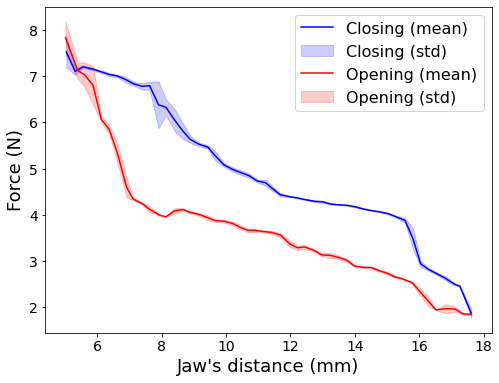

In [30]:
# Graph of force vs distance of scissors
data_scissors_position_mm = distance_to_mm(data_scissors["position"])
data_scissors_force = arduino_to_voltage(data_scissors["force"])
scissors_force = get_force(data_scissors_force)

get_grouped_data(data_scissors_position_mm, scissors_force, tool_name = "Scissors" )

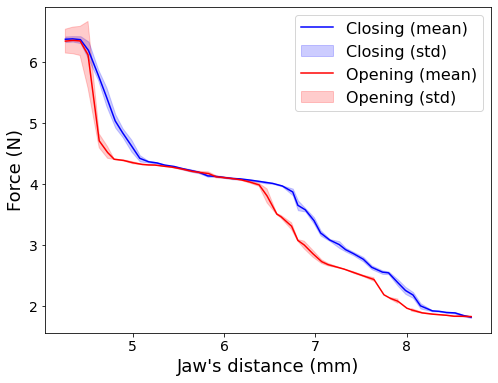

In [31]:
# Graph of force vs distance of forceps
data_forceps_position_mm = distance_to_mm(data_forceps["position"])
data_forceps_force = arduino_to_voltage(data_forceps["force"])
forceps_force = get_force(data_forceps_force)

get_grouped_data(data_forceps_position_mm, forceps_force, tool_name = "Forceps" )

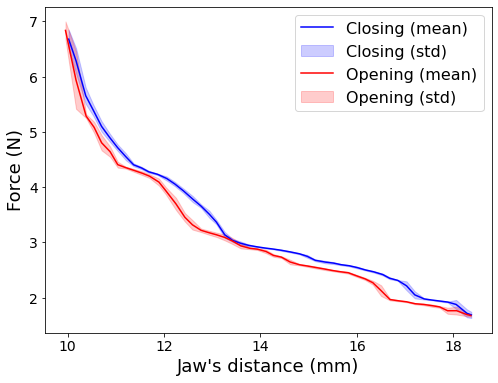

In [32]:
# Graph of force vs distance of needle holder
data_needle_holder_position_mm = distance_to_mm(data_needle_holder["position"])
data_needle_holder_force = arduino_to_voltage(data_needle_holder["force"])
needle_holders_force = get_force(data_needle_holder_force)

get_grouped_data(data_needle_holder_position_mm, needle_holders_force, tool_name = "Needle Holder" )

Text(0, 0.5, 'Force')

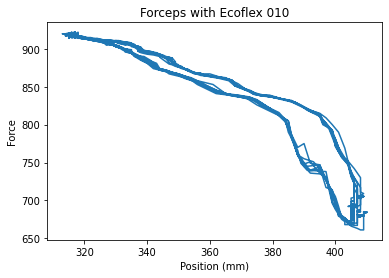

In [15]:
plt.plot(data_soft["position"], data_soft["force"])
plt.title("Forceps with Ecoflex 010")
plt.xlabel("Position (mm)")
plt.ylabel("Force")

Text(0, 0.5, 'Force')

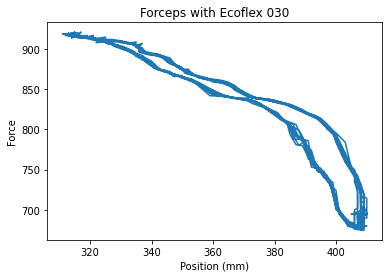

In [16]:
plt.plot(data_hard["position"], data_hard["force"])
plt.title("Forceps with Ecoflex 030")
plt.xlabel("Position (mm)")
plt.ylabel("Force")

In [17]:
data_needle_holder["position"] = (data_needle_holder["position"] - 275) *0.04
data_needle_holder["force"] = (data_needle_holder["force"] / 1023)*5

Text(0, 0.5, 'Force')

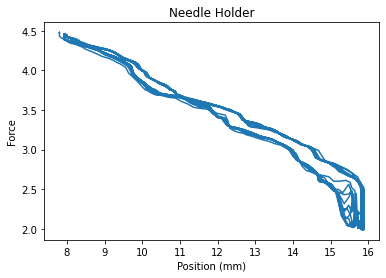

In [18]:
plt.plot(data_needle_holder["position"], data_needle_holder["force"])
plt.title("Needle Holder")
plt.xlabel("Position (mm)")
plt.ylabel("Force")

Text(0, 0.5, 'Force')

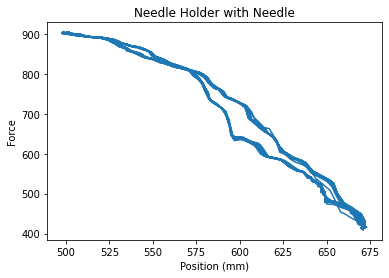

In [19]:
plt.plot(data_needle["position"], data_needle["force"])
plt.title("Needle Holder with Needle")
plt.xlabel("Position (mm)")
plt.ylabel("Force")